# CAMELYON16

In [434]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [639]:
# GPU check

## Background

link to CAMELYON16

link to Harvard ppt

https://gist.github.com/ajsander/b65061d12f50de3cef5d#file-fcn_tutorial-ipynb

linke to Craig's paper link

## Load data

In [843]:
import os.path as osp
import openslide

BASE_TRUTH_DIR = 'data/Ground_Truth_Extracted/Mask'

slide_path = 'data/slides/Tumor_009.tif'
truth_path = osp.join(BASE_TRUTH_DIR, 'Tumor_009_Mask.tif')

slide = openslide.open_slide(slide_path)
truth = openslide.open_slide(truth_path)

"Original Slide dimensions %dx%d" % slide.dimensions
"Original Truth dimensions %dx%d" % truth.dimensions

'Original Slide dimensions 97792x217088'

'Original Truth dimensions 97792x217088'

These slides are huge -- 21 billion pixels!  We'll break this huge image into 256x256x3 patches for training.

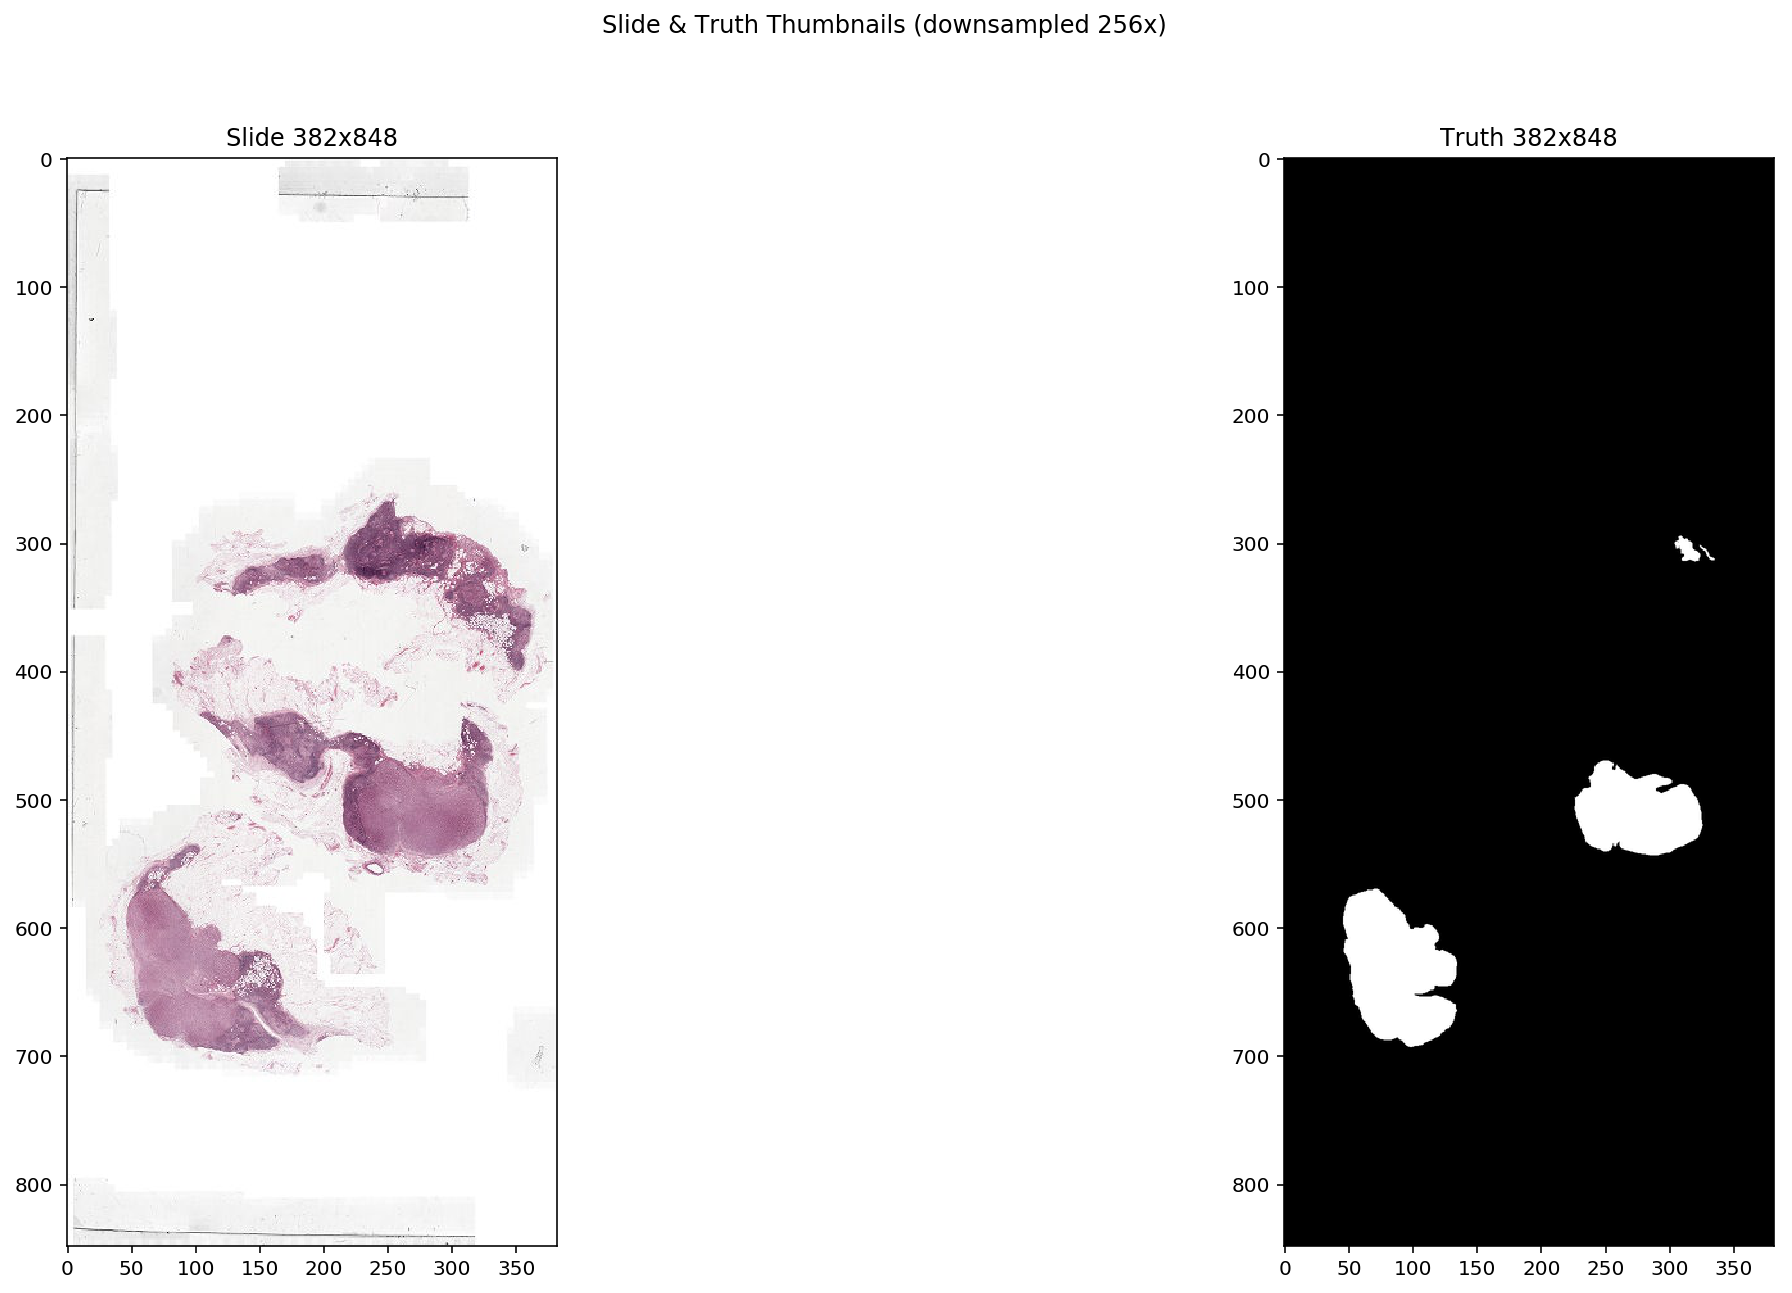

In [373]:
thumbnail = slide.get_thumbnail((slide.dimensions[0] / 256, slide.dimensions[1] / 256)) 
thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) 

f, axes = plt.subplots(1, 2, figsize=(20, 10));
ax = axes.ravel()
ax[0].imshow(thumbnail);
ax[0].set_title('Slide %dx%d' % thumbnail.size)
ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
f.suptitle('Slide & Truth Thumbnails (downsampled 256x)');

Each pixel in these thumbnails corresponds to a 256x256 patch that can be used for training.  White areas in truth mask are cancer regions.

## Tissue area selection

We can use Otsu's method to find areas on slide with tissue.  Pixels with binary==False will be set of patches available for training.

In [4]:
from skimage.filters import threshold_otsu

img = np.array(thumbnail.convert('L')) # convert to grayscale
thresh = threshold_otsu(img)
binary = img > thresh

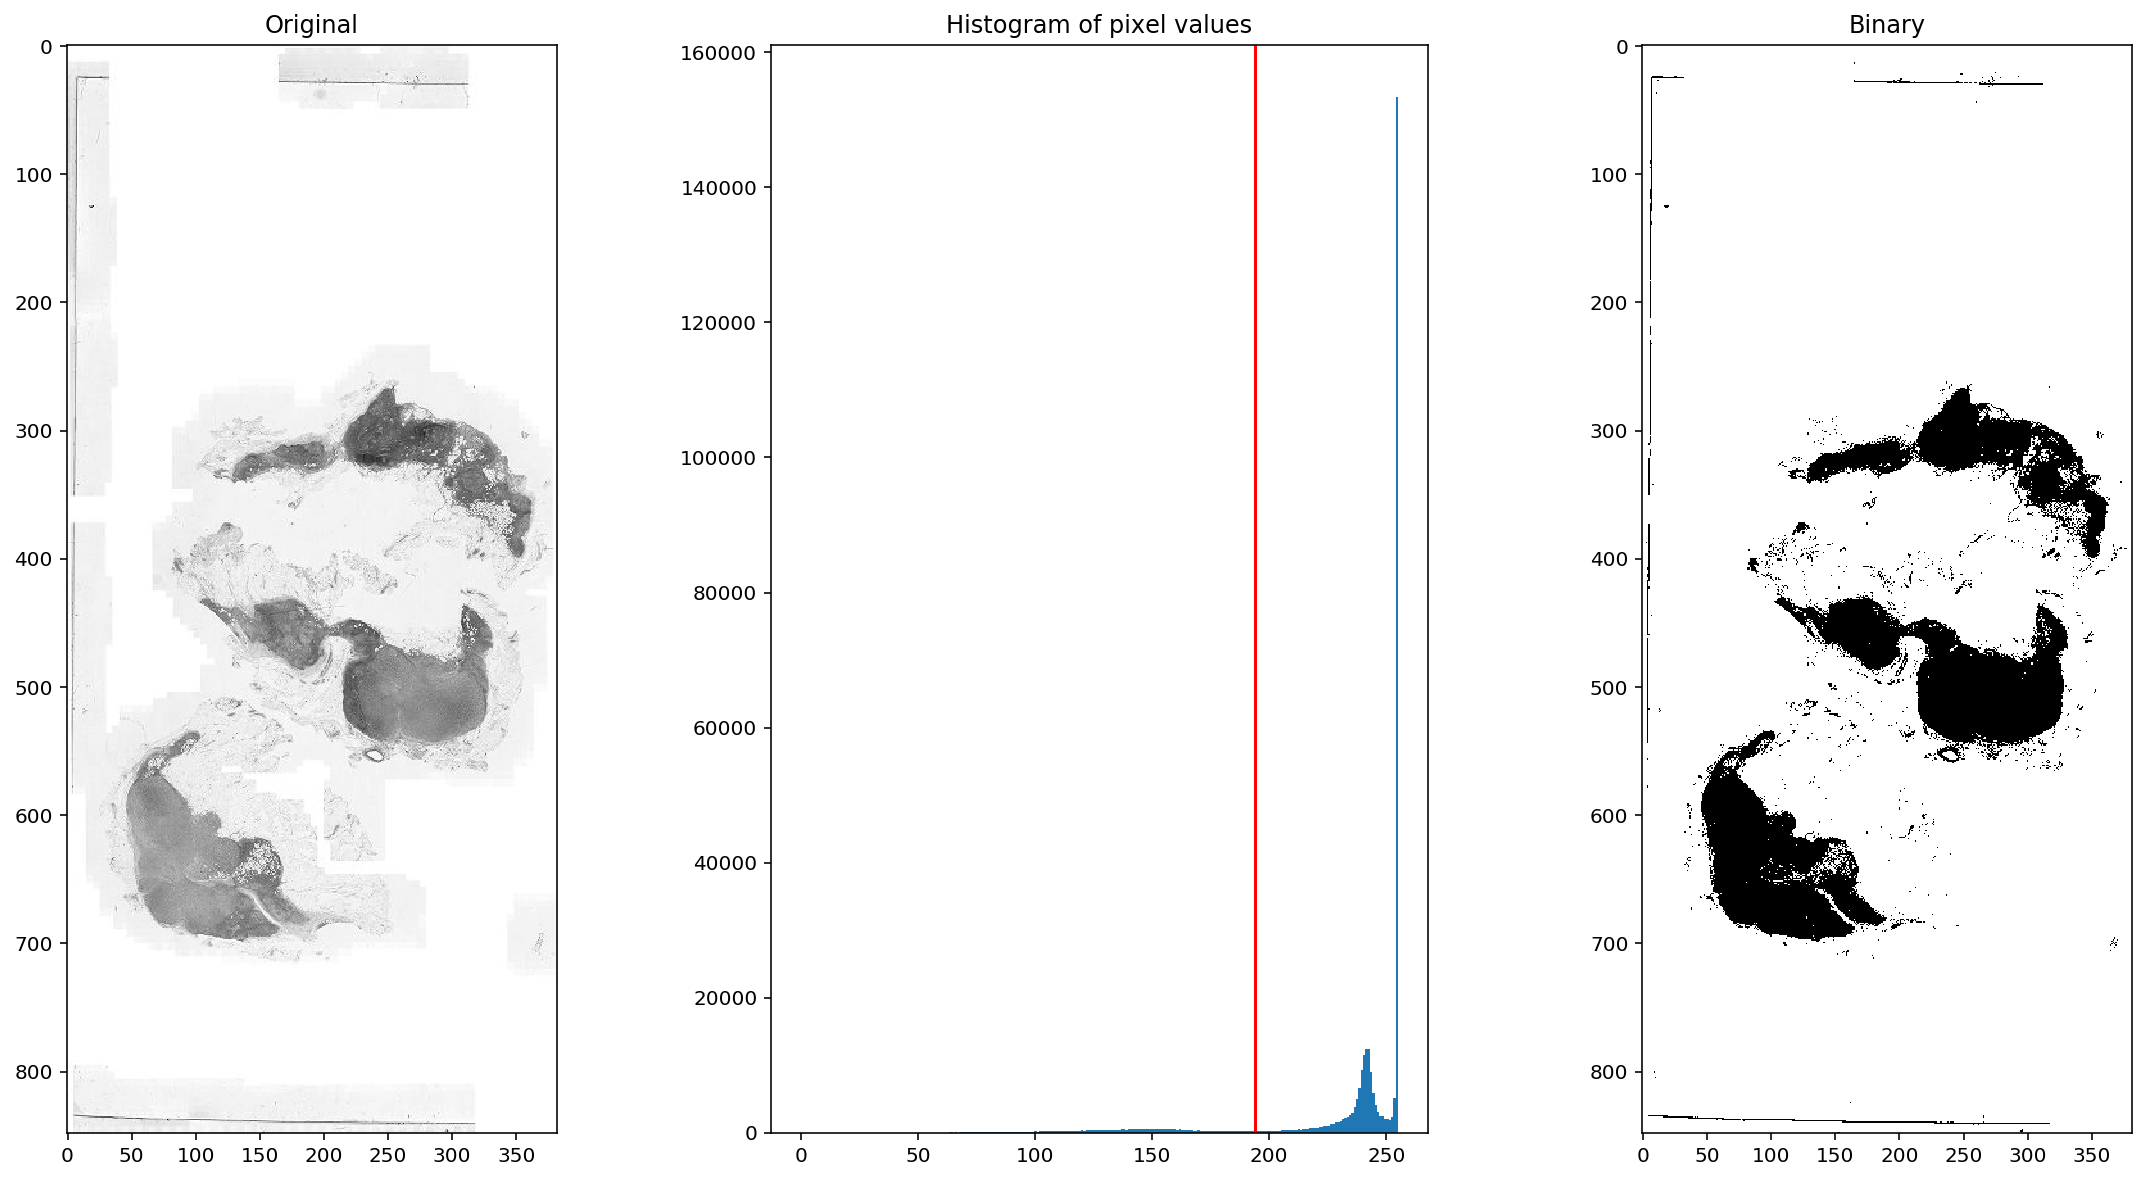

In [5]:
f, axes = plt.subplots(1, 3, figsize=(20, 10));
ax = axes.ravel();
ax[0].imshow(img, cmap='gray');
ax[0].set_title('Original');
ax[1].hist(img.ravel(), bins=256);
ax[1].set_title('Histogram of pixel values');
ax[1].axvline(thresh, color='r');
ax[2].imshow(binary, cmap='gray');
ax[2].set_title('Binary');

## Example Patches

In [6]:
from openslide.deepzoom import DeepZoomGenerator 

tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
tiles_truth = DeepZoomGenerator(truth, tile_size=256, overlap=0, limit_bounds=False)

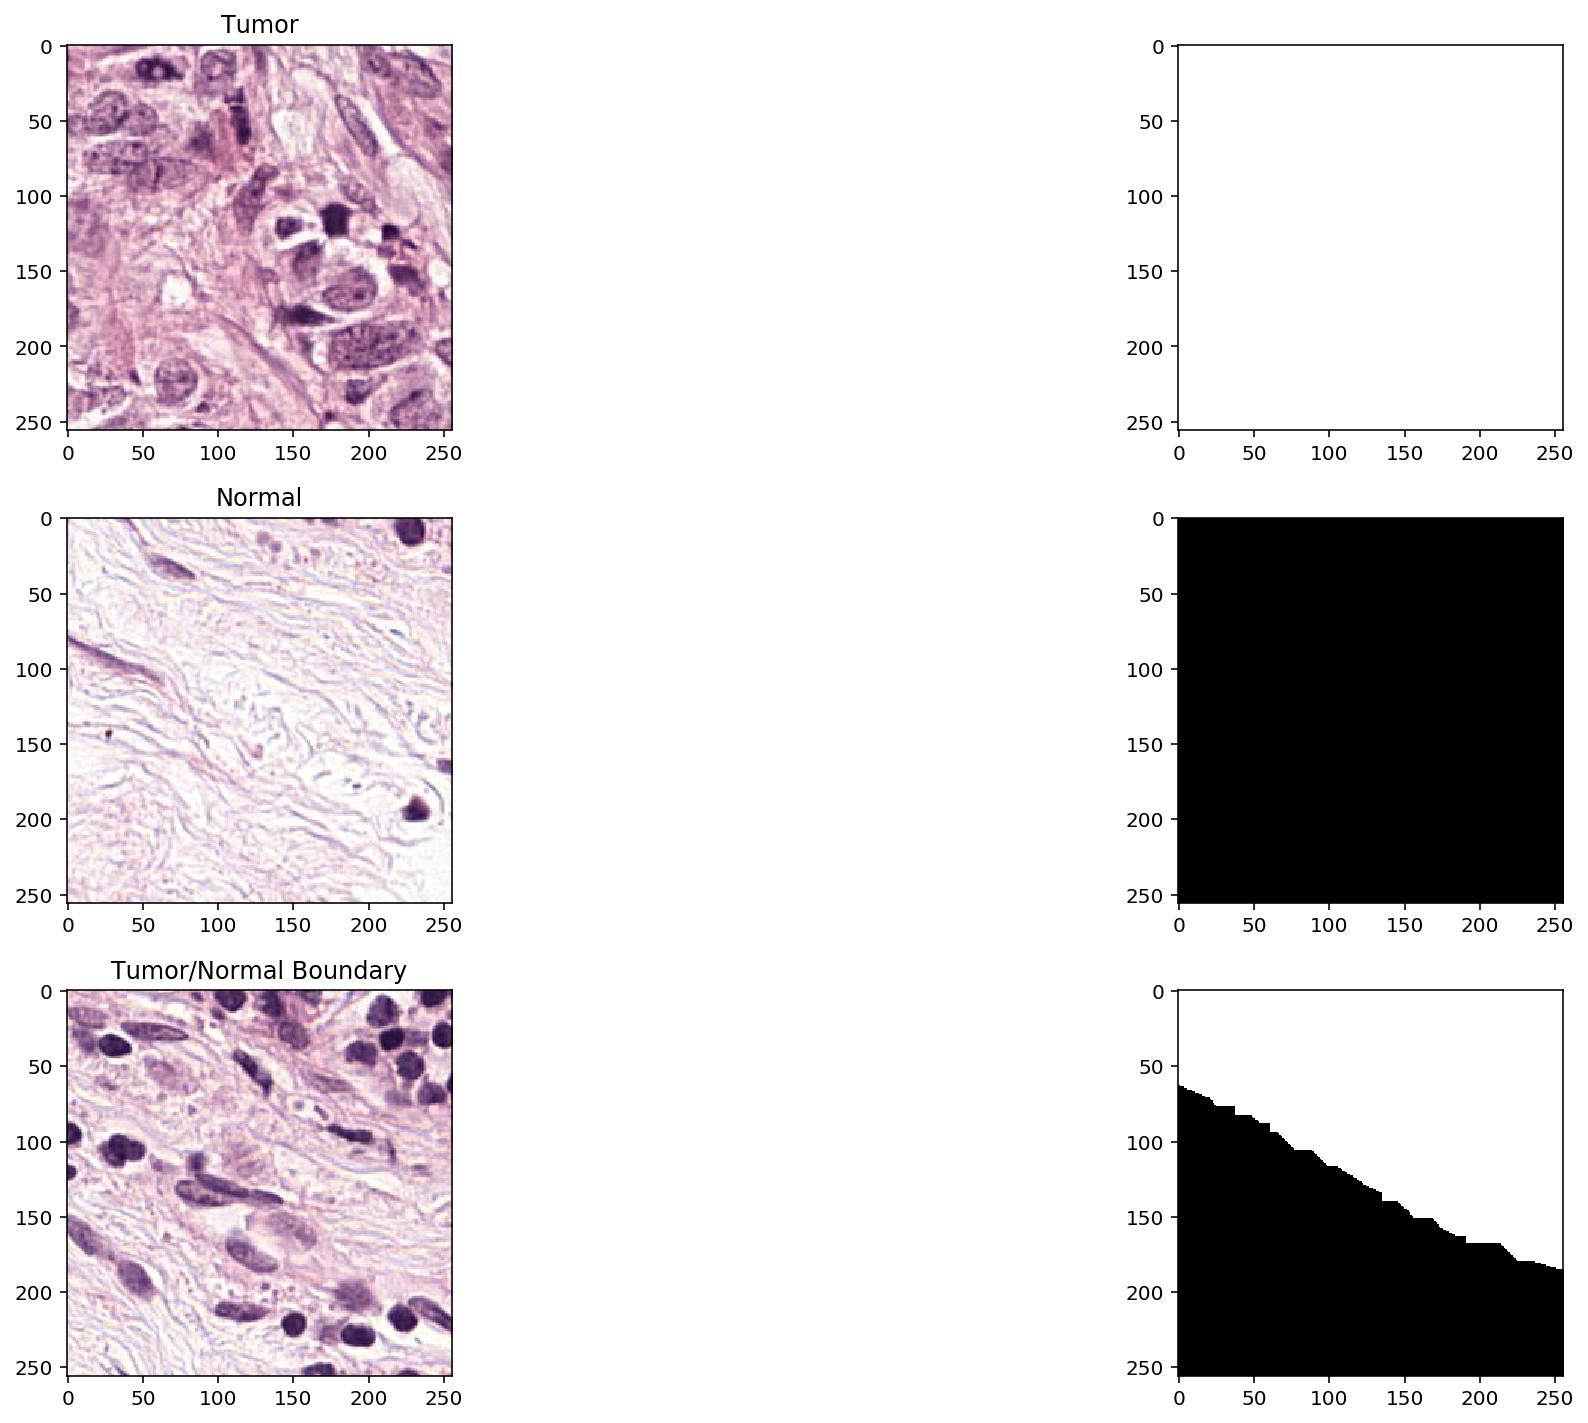

In [7]:
f, axes = plt.subplots(3, 2, figsize=(20, 10))
axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (100, 680)));
axes[0, 0].set_title('Tumor')
axes[0, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (100, 680)));
axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (97, 693)));
axes[1, 0].set_title('Normal')
axes[1, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (97, 693)));
axes[2, 0].imshow(tiles.get_tile(tiles.level_count-1, (97, 692)));
axes[2, 0].set_title('Tumor/Normal Boundary')
axes[2, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (97, 692)));
plt.tight_layout();

The boundary example will probably be challenging to predict correctly.

## Data generator

In [226]:
def find_patches_from_slide(slide_path, base_truth_dir=BASE_TRUTH_DIR):
    """Returns a dataframe of all patches in slide
    """
    base_truth_dir = Path(base_truth_dir)
    slide_contains_tumor = osp.basename(slide_path).startswith('Tumor_')
    
    with openslide.open_slide(slide_path) as slide:
        thumbnail = slide.get_thumbnail((slide.dimensions[0] / 256, slide.dimensions[1] / 256))
    
    thumbnail_grey = np.array(thumbnail.convert('L')) # convert to grayscale
    thresh = threshold_otsu(thumbnail_grey)
    binary = thumbnail_grey > thresh
    
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches['is_tissue'] = ~patches[0]
    patches.drop(0, axis=1, inplace=True)
    patches['slide_path'] = slide_path
    
    if slide_contains_tumor:
        truth_slide_path = base_truth_dir / osp.basename(slide_path).replace('.tif', '_Mask.tif')
        with openslide.open_slide(str(truth_slide_path)) as truth:
            thumbnail_truth = truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) 
        
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        patches_y.drop(0, axis=1, inplace=True)

        samples = pd.concat([patches, patches_y], axis=1)
    else:
        samples = patches
        samples['is_tumor'] = False
    
    samples = samples[samples.is_tissue == True] # remove patches with no tissue
    samples['tile_loc'] = list(samples.index)
    samples.reset_index(inplace=True, drop=True)
    return samples
    
samples = find_patches_from_slide('data/slides/Tumor_009.tif')
print('Total patches in slide: %d' % len(samples))
samples.iloc[:10]
samples.is_tumor.value_counts()

Total patches in slide: 34521


is_tissue                 slide_path is_tumor   tile_loc
0      True  data/slides/Tumor_009.tif    False  (13, 165)
1      True  data/slides/Tumor_009.tif    False  (14, 165)
2      True  data/slides/Tumor_009.tif    False  (21, 275)
3      True  data/slides/Tumor_009.tif    False  (22, 248)
4      True  data/slides/Tumor_009.tif    False  (22, 249)
5      True  data/slides/Tumor_009.tif    False    (24, 8)
6      True  data/slides/Tumor_009.tif    False    (24, 9)
7      True  data/slides/Tumor_009.tif    False   (24, 10)
8      True  data/slides/Tumor_009.tif    False   (24, 11)
9      True  data/slides/Tumor_009.tif    False   (24, 12)

False    20904
True     13617
Name: is_tumor, dtype: int64

This slide has 34.5k patches containing tissue. Roughly 39% of these patches contain tumor cells.

In [643]:
from keras.utils.np_utils import to_categorical

NUM_CLASSES = 2 # not_tumor, tumor

def gen_imgs(samples, batch_size):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, 256, 256, 3]
        y: tensor, int32 - [batch_size, 256, 256, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    intput: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    """
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = samples.sample(frac=1) # shuffle samples
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
        
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows():
                slide_contains_tumor = osp.basename(batch_sample.slide_path).startswith('Tumor_')
                
                with openslide.open_slide(batch_sample.slide_path) as slide:
                    tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
                    img = tiles.get_tile(tiles.level_count-1, batch_sample.tile_loc[::-1])
                    
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    with openslide.open_slide(str(truth_slide_path)) as truth:
                        truth_tiles = DeepZoomGenerator(truth, tile_size=256, overlap=0, limit_bounds=False)
                        mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                else:
                    mask = np.zeros((256, 256))

                images.append(np.array(img))
                masks.append(mask)

            X_train = np.array(images)
            y_train = np.array(masks)
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], 256, 256, 2)
            yield X_train, y_train

Note:
>Our model output and label tensors are of shape batch_sizex256x256x2.  So for each pixel we have a probability that they belong to class [not_tumor, tumor].  Label tensors are binary [0, 1].

In [500]:
sample_gen = gen_imgs(samples, 32)

In [501]:
X, y  = next(sample_gen)

In [641]:
X.shape

(32, 256, 256, 3)

In [574]:
y.shape

(32, 256, 256, 2)

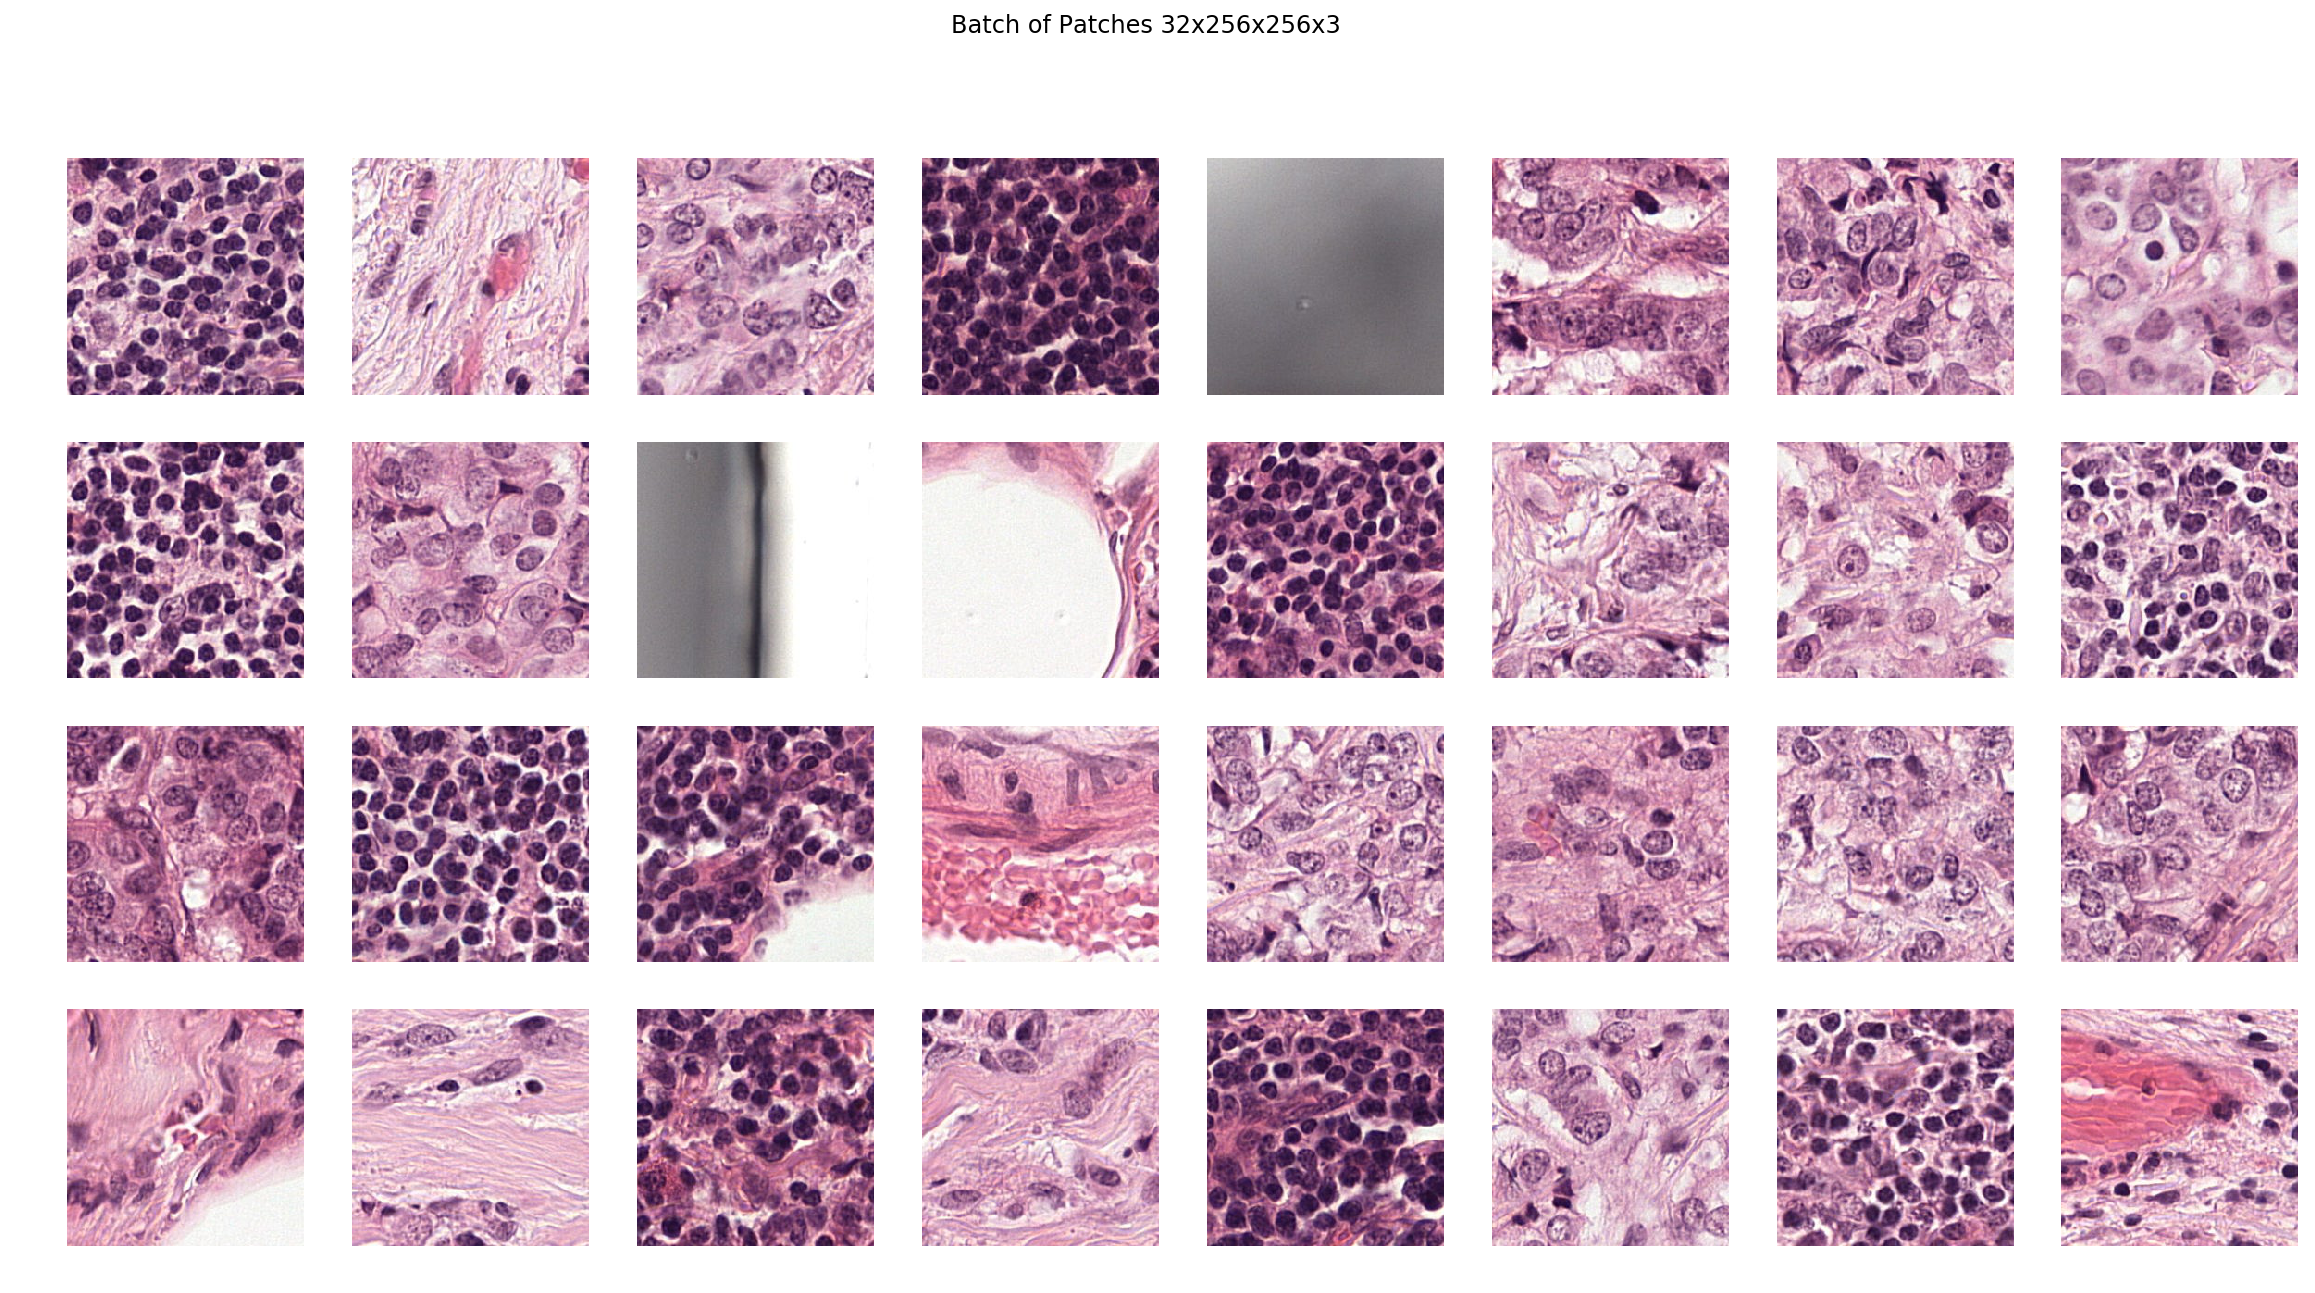

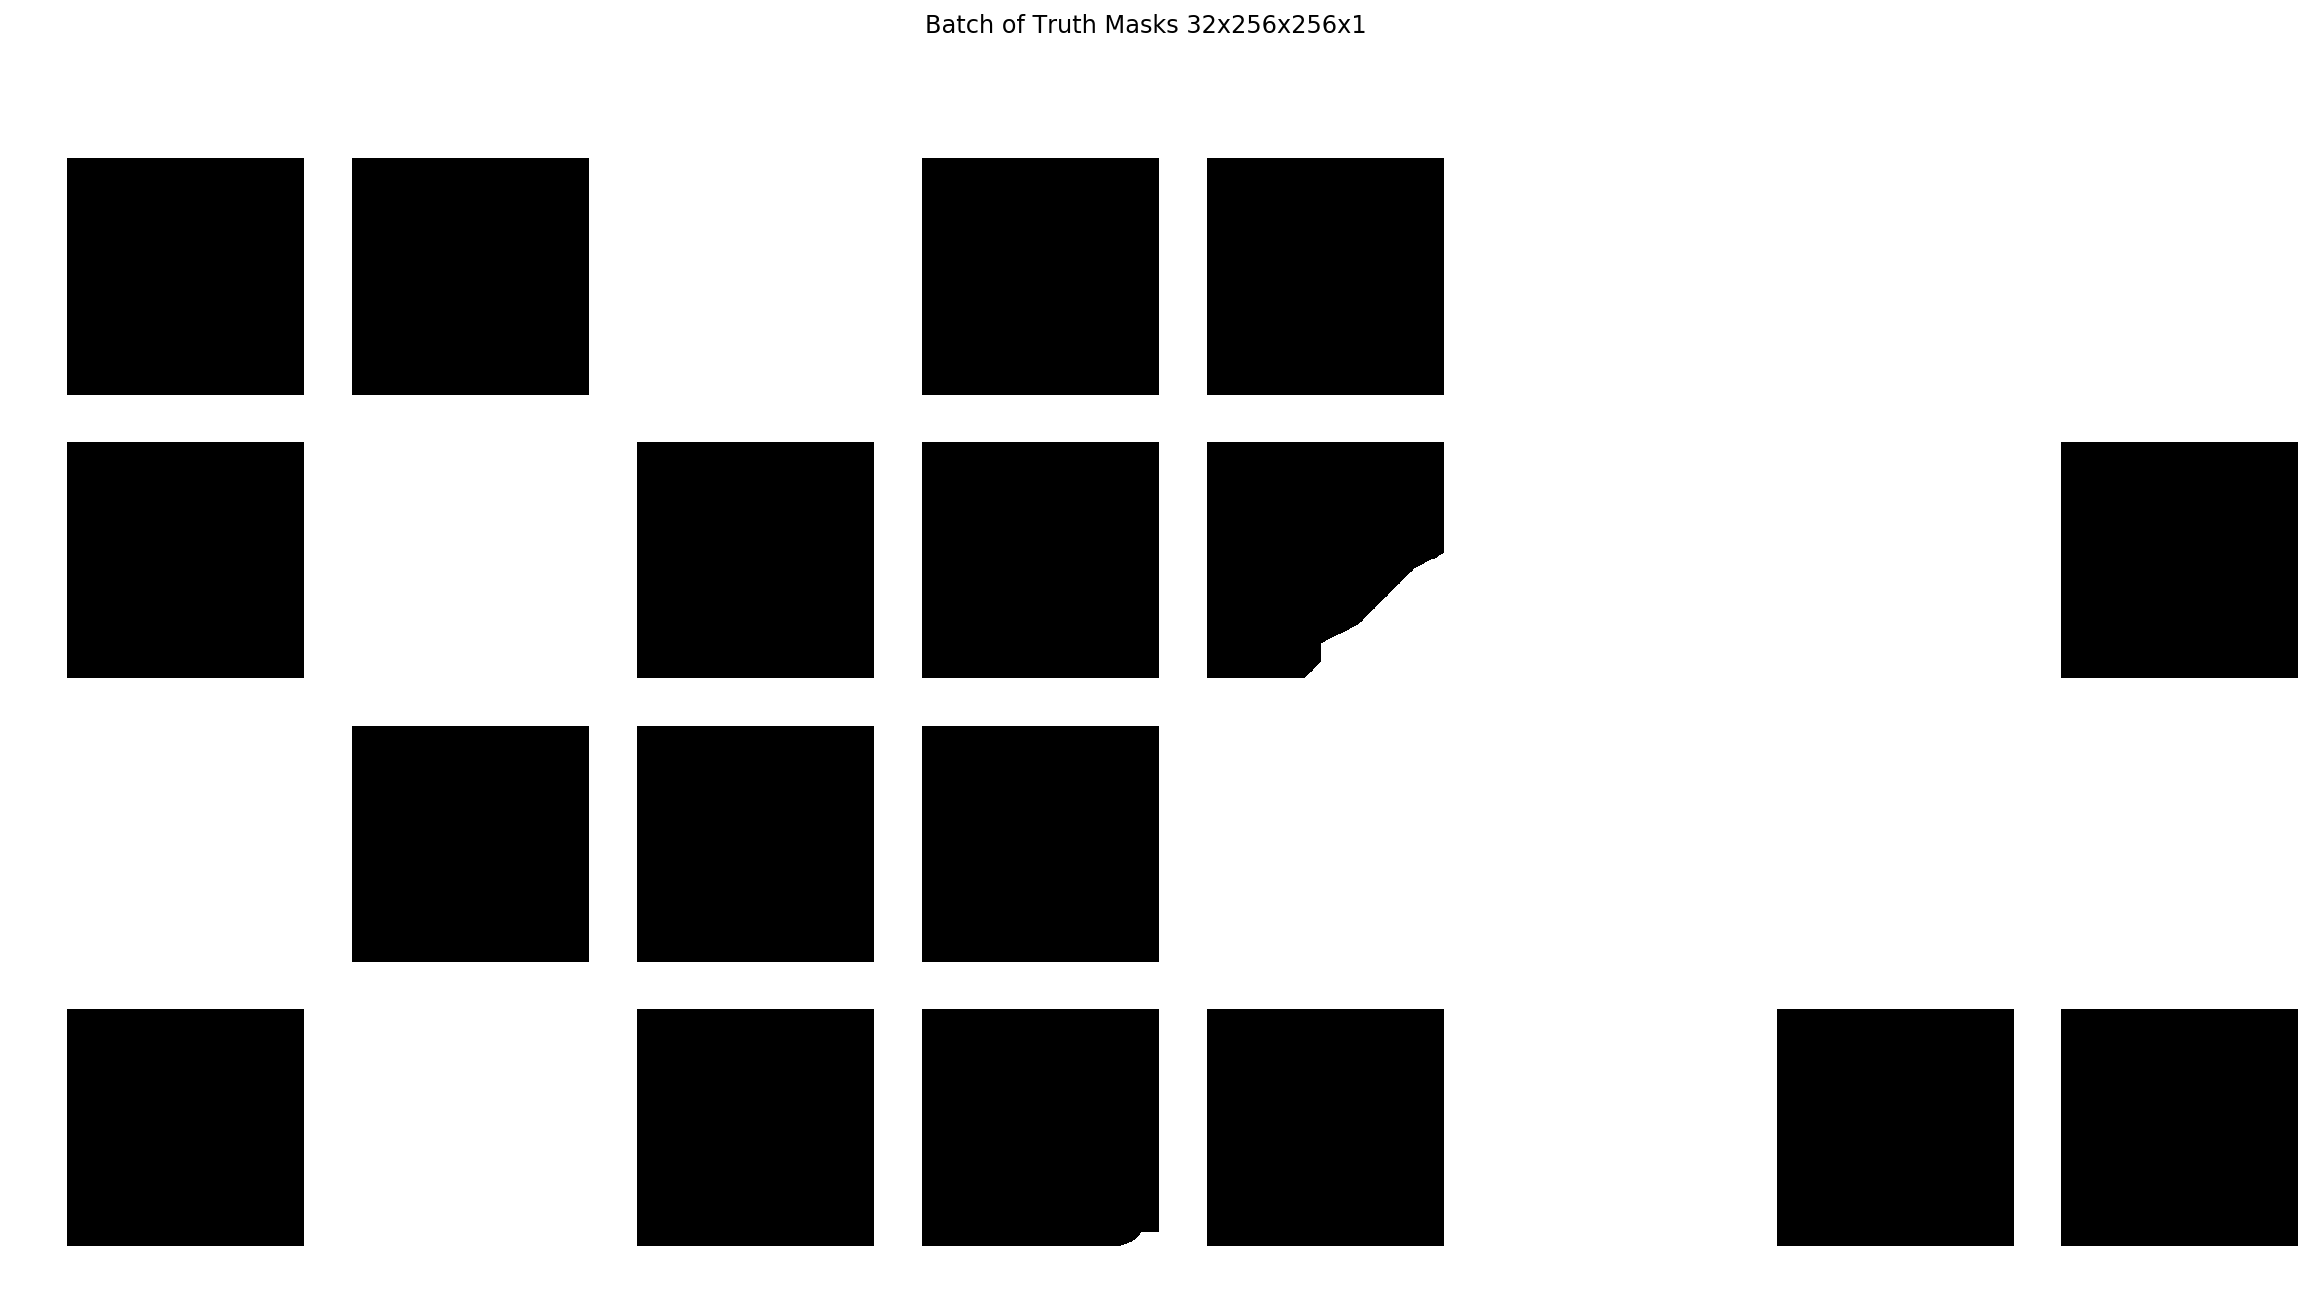

In [580]:
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, X.shape[0]):
    _ = ax[i].imshow(X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, X.shape[0]):
    _ = ax[i].imshow(y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

In [586]:
# will use these later for testing model's prediction
example_patch = X[-10]
example_truth = y[-10]

## Define network

This first image segmentation model is based on a fully convolutional network used to predict the left ventricle from cardiac MRI scans (described [here](https://gist.github.com/ajsander/b65061d12f50de3cef5d#file-fcn_tutorial-ipynb)).

Architecture:

1. Convolution1, 5 x 5 kernel, stride 2, outputs 128x128x100
2. Maxpooling1, 2 x 2 window, stride 2, outputs 64x64x100
3. Convolution2, 5 x 5 kernel, stride 2, outputs 32x32x200
4. Maxpooling2, 2 x 2 window, stride 2, outputs 16x16x200
5. Convolution3, 3 x 3 kernel, stride 1, outputs 16x16x300
6. Convolution4, 3 x 3 kernel, stride 1, outputs 16x16x300
7. Convolution5, 1x1 kernel, stride 1, outputs 16x16x2
8. Deconvolution, 31 x 31 kernel, stride 16, outputs 256x256x2

This network is XXX layers deep with XXXX connections and XXX parameters.

In [592]:
from keras.models import Sequential
from keras.layers import Lambda
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
model.add(Convolution2D(100, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
# add dropout here eventually
model.add(Convolution2D(2, (1, 1)))
model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

## Train model

In [ ]:
BATCH_SIZE = 32
N_EPOCHS = 5

In [593]:
samples = find_patches_from_slide(slide_path)
samples = samples.sample(1000, random_state=42)
samples.reset_index(drop=True, inplace=True)

In [594]:
from sklearn.model_selection import StratifiedShuffleSplit

# ensure train and validation sets have same proportions of tumor patches
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(samples, samples["is_tumor"]):
        train_samples = samples.loc[train_index]
        validation_samples = samples.loc[test_index]

In [595]:
# Train model
## TODO Add checkpoint mechanism

train_generator = gen_imgs(train_samples, BATCH_SIZE)
validation_generator = gen_imgs(validation_samples, BATCH_SIZE)

model.fit_generator(train_generator, np.ceil(len(train_samples) / BATCH_SIZE),
    validation_data=validation_generator,
    validation_steps=np.ceil(len(validation_samples) / BATCH_SIZE),
    epochs=N_EPOCHS)

Epoch 1/5
25/25 [==============================] - 157s - loss: 0.6044 - val_loss: 0.5298

## Evaluate model

In [747]:
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(example_patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

In [839]:
import matplotlib.gridspec as gridspec

def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, 255, dx)
    y = np.arange(0, 255, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = cv2.cvtColor(patch, code=cv2.COLOR_RGB2GRAY)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='jet', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.75):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='jet', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')

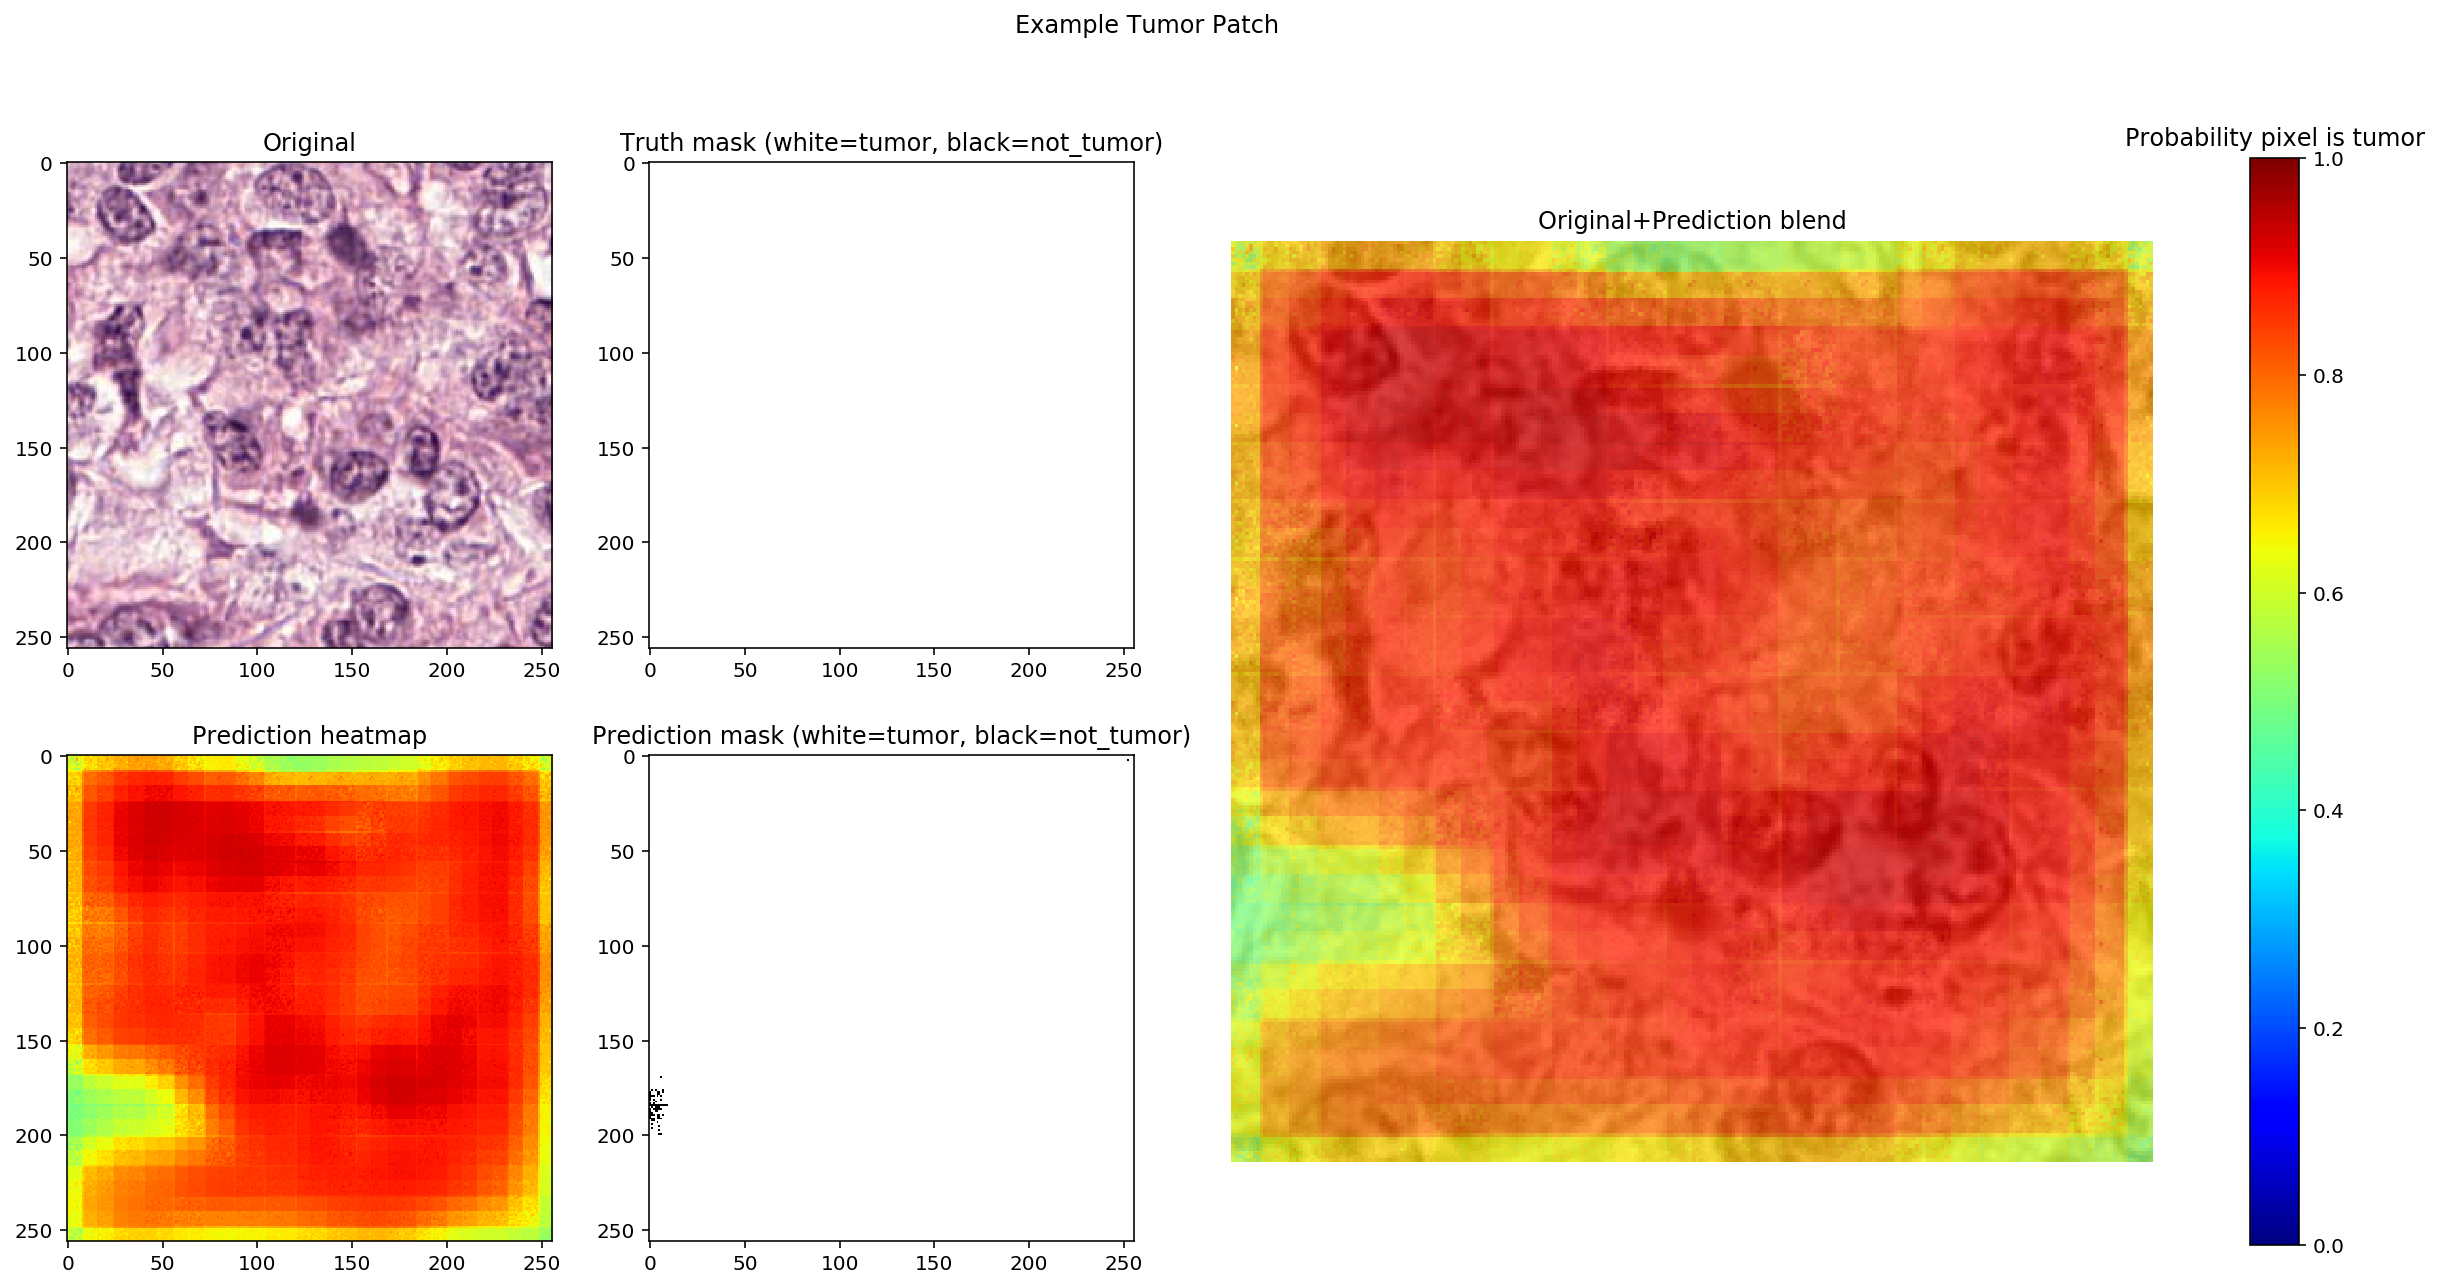

In [841]:
prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')

We seem to be predicting well overall for this patch.  We do perform worse on the edges and the lower left bit.

count    65536.000000
mean         0.823636
std          0.090335
min          0.464354
25%          0.791528
50%          0.856142
75%          0.885828
max          0.942156
dtype: float64


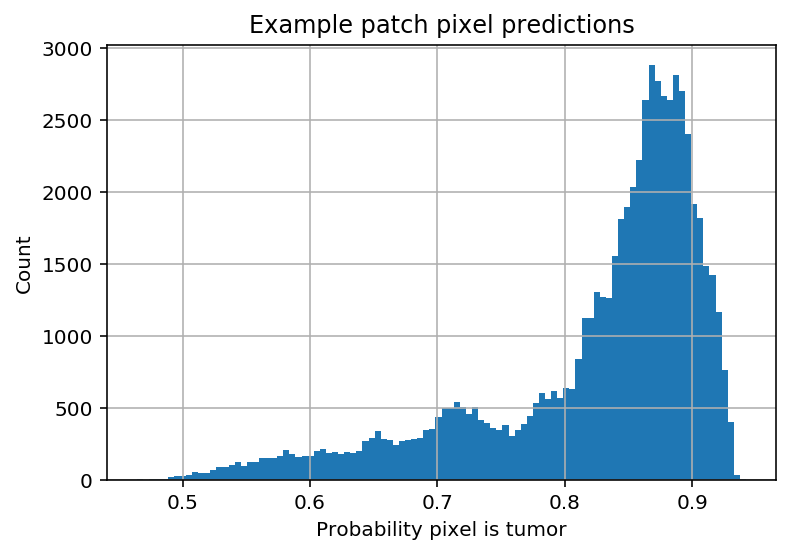

In [817]:
pred_s = pd.Series(prediction.flatten())
print(pred_s.describe())
ax = pred_s.hist(bins=100);
ax.set_title('Example patch pixel predictions');
ax.set_ylabel('Count');
ax.set_xlabel('Probability pixel is tumor');

In [ ]:
# Next:

# back up everything on github
# plot more examples (write get_rando_sample function)
# setup on aws, rerun all slides
# predict every single patch in Tumor_0009.tif
# plot full slide prediction (try both max and avg downscaling methods)
# calculate performance metrics (accuracy, recall, precision, F1, Dice cooefficient)

## TODOs

In [644]:
# Add 'on-the-fly' data augmentations.  Flip, rotate, crop, shift, etc.

In [ ]:
# Train on larger dataset (add dropout)

In [ ]:
# Try different networks